# Intro to PSFMachine Tutorial 1.0

In [1]:
import numpy as np
import psfmachine as pm
import lightkurve as lk
import matplotlib.pyplot as plt

In [2]:
import warnings
from scipy import sparse
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)

## Target Pixel Files

In this tutorial we will see how `PSFMachine` can be used to do PSF photmetry and extract light curves from Kepler/K2 data.

TPFs are dta products created by Kepler, K2 and TESS missions. It contain custom cutouts of the full telescope CCD around selected targets.
Each file contains about 5x5 pixels around the target and all the available cadences. 
But many of these TPFs also contain background sources that can be easily isolated or blended. Kepler and TESS pipelines only created
light curves for main targets but there are many sources (~270,000 background sources in Kepler TPFs down to 18th g mag) that can be
extracted to create new light curves. `PSFMachine` provides the tools to create these new light curves.

We can download these files using the `LightKurve` package by specifying the target name, mission, quarter of observation, etc.
Let's download 200 TPFs around Kepler-16 observed during quarter 5

In [3]:
tpfs = lk.search_targetpixelfile('Kepler-16', mission='Kepler', quarter=5, 
                                 radius=1000, limit=200, cadence='long'
                                ).download_all(quality_bitmask=None)

## TPFMachine

As explained in the [LFD paper](https://ui.adsabs.harvard.edu/abs/2021AJ....162..107H/abstract), `PSFMachine` performs PSF photometry
of all sources (using Gaia as source catalog) in the TPFs. 
To create a `PSFMachine` object from TPFs, we use the submodule `TPFMachine` that includes useful methods to parse and work with 
TPF data. We'll do this using `pm.TPFMachine.from_TPFs()` which inputs a collection of TPFs.

Printing the new `machine` object will tell us how many sources are in the TPFs pixels, the number of cadences, and 
total number of pixel data.

In [4]:
machine = pm.TPFMachine.from_TPFs(tpfs)
machine

TPFMachine (N sources, N times, N pixels): (358, 4486, 8043)

To see the source catalog, we can use the attribute `machine.sources`

In [5]:
machine.sources

,designation,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_flux,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,clean_flag,tpf_id
0,Gaia DR2 2133289365203000320,289.305515,51.751214,3.360764,0.063723,-37.067105,-3.309759,5019.046019,16.436813,17.465061,15.387713,0,None
1,Gaia DR2 2133289433922484608,289.297954,51.767697,1.343142,0.022050,-5.879892,-24.727121,197183.748119,12.451188,12.745221,12.003183,0,12645102
2,Gaia DR2 2133289713099361024,289.360440,51.788566,0.890293,0.029919,0.233968,-5.551846,14096.924486,15.315555,15.737226,14.744886,0,12645197
3,Gaia DR2 2133289300782483584,289.290589,51.730932,0.733541,0.055284,-2.811023,-5.691464,4160.107938,16.640604,17.211700,15.938039,0,12645090
4,Gaia DR2 2133289300782483456,289.285890,51.734269,3.594274,0.018049,-31.035969,-0.115374,44269.964465,14.073092,14.699276,13.328061,0,12645081
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,Gaia DR2 2133262530247167616,289.324552,51.582686,1.577407,0.041454,-2.280064,-10.978653,6981.631420,16.078474,16.834944,15.244086,0,12554848
354,Gaia DR2 2133286169747793536,289.336295,51.627478,0.673330,0.022100,-5.860089,-6.680626,150043.876640,12.747820,13.327343,12.051364,0,12600463
355,Gaia DR2 2133287784654998784,289.259785,51.715759,0.883978,0.029352,3.368384,1.636531,11823.664470,15.506486,16.026752,14.848104,0,12645045
356,Gaia DR2 2133287136118954368,289.248472,51.652656,0.921971,0.017441,1.542597,-9.658225,44757.043147,14.061213,14.411454,13.555089,0,12600314


## Create Light Curves

To create light curves, we just have to do `machine.fit_lightcurves()`. This method will fit a PSF model to all the sources available simultaneously,
use the `pos_corr` to remove velocity aberration from the scene, and will use these two model to obtain the PSF flux. Also, the method will
do aperture photometry (SAP) on all sources where each aperture is defined accordingly to the PSF profile.
Setting `plot=True` will show diagnostic plots for the PSF model and the time model.

For more details on how the PSF shape mode and time model fitting work, see the LFD paper and the more detailed tutorial 
for `PSMachine` **Tutorial_11_TPFs**.

`machine.fit_lightcurves()` will create the new attribute `machine.lcs` with the new light curves as `lk.LightCurveCollection` object.

SAP: 100%|██████████| 358/358 [00:00<00:00, 786.18it/s]


using pos_corrs
using pos_corrs


Fitting 358 Sources (w. VA): 100%|██████████| 4486/4486 [05:45<00:00, 12.99it/s]


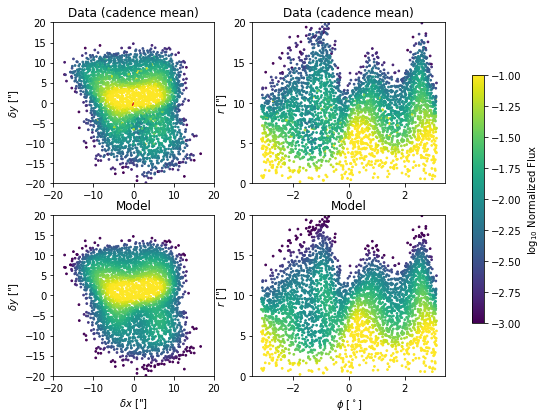

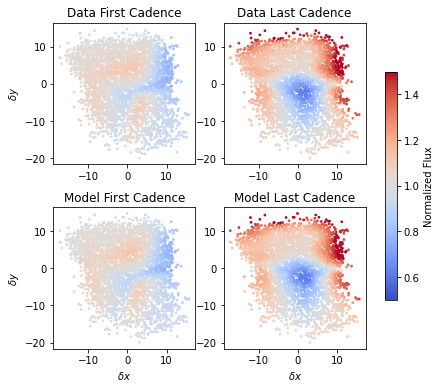

In [6]:
machine.fit_lightcurves(plot=True)

Let's see our new light curves:

In [7]:
machine.lcs[0]

time,flux,flux_err,psf_flux_NVA,psf_flux_err_NVA,sap_flux,sap_flux_err
,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s
object,float64,float64,float64,float64,float64,float64
2455276.4906453583,7395.812199201318,7.971796737956673,5719.907674419965,8.034220729227876,46285.89453125,7.097999095916748
2455276.5110794757,7450.18332520767,7.975492388720457,5773.196260580198,8.037663634671375,46331.95703125,7.1005330085754395
2455276.531513393,7415.588441859576,7.974258781108861,5740.015101966903,8.036847472971024,46333.90625,7.100830078125
2455276.5519474107,7406.490269753793,7.974075136801611,5729.673273582325,8.036565036387152,46338.5078125,7.100911617279053
2455276.572381528,7433.2770374671,7.974953199211132,5757.677885928049,8.037636911386652,46352.56640625,7.101462364196777
2455276.592815446,7423.317561011839,7.974381880922947,5746.95184444323,8.037182838366233,46367.4296875,7.102295875549316
2455276.613249464,7440.194464446302,7.974988452648132,5764.496065805069,8.037879465854742,46394.33984375,7.103224754333496
2455276.6336835823,7443.314413576765,7.9744980667175485,5767.959171894914,8.037461098382858,46402.6015625,7.1036882400512695


The `lightkurve` object has 7 columns:

* `time`: the observing time in MJD
* `flux` and `lux_err`: have the PSF photometry corrected for velocity aberration
* `flux_NVA` and `lux_err_NVA`: have the PSF photometry without correction for velocity aberration
* `sap_flux` and `sap_lux_err`: have the aperture photometry
    
Because each element in `machine.lcs` is a `lightkurve.LightKurve` object, we can use all the functionalities the library
offers, like plotting, saving to FITS, doing periodograms, etc.

## Plot Light Curves

Kepler-16 (KIC 12644769) is a binary system with a K-type MS star and a M-type red dwarf. Let's see how its light curve looks like:

In [8]:
machine.sources[machine.sources.tpf_id == 12644769]

,designation,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_flux,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,clean_flag,tpf_id
286,Gaia DR2 2133476355197071616,289.075798,51.757299,13.289317,0.027089,14.040673,-48.600997,377116.635549,11.747176,12.558092,10.884203,0,12644769


<AxesSubplot:xlabel='Time [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

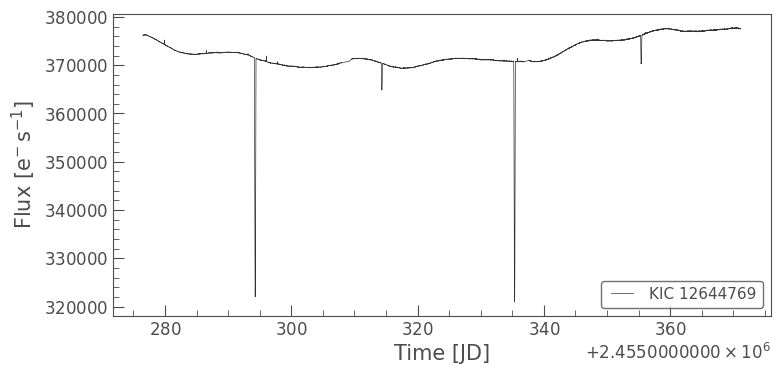

In [9]:
machine.lcs[286].plot()

What about other light curve in the data:

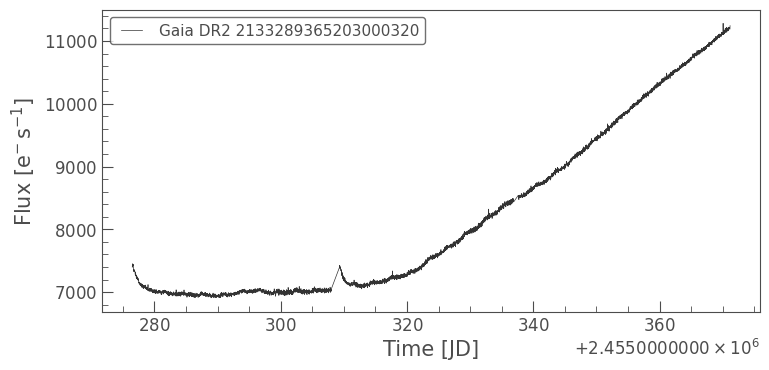

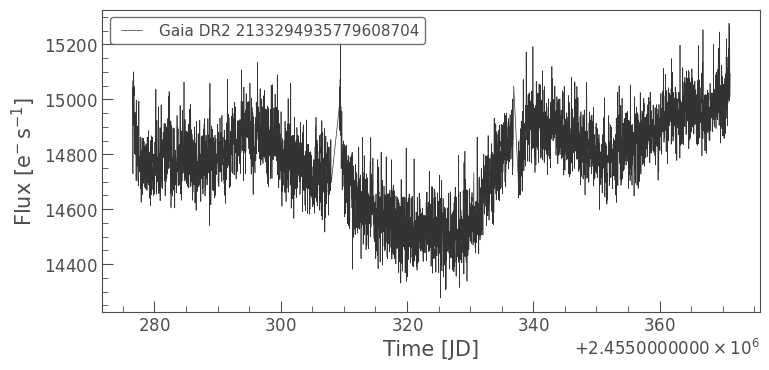

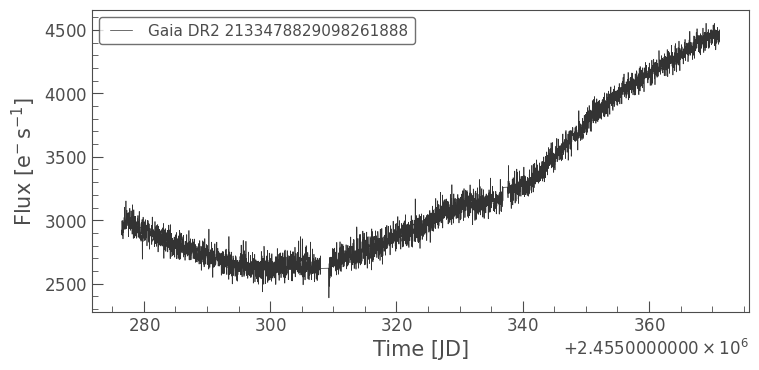

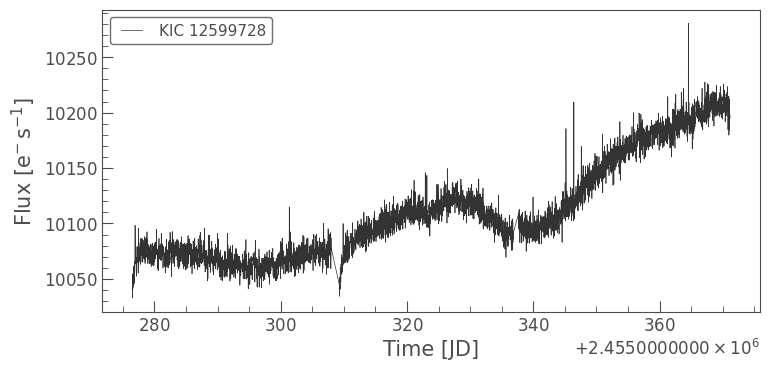

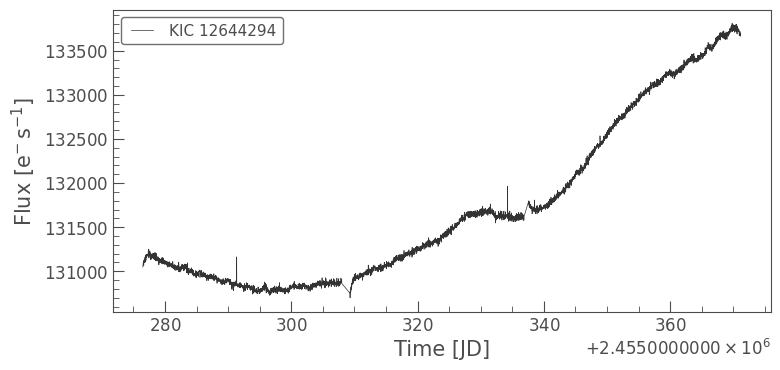

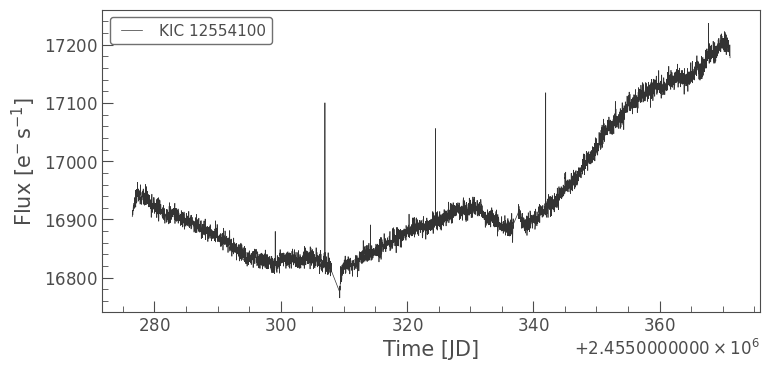

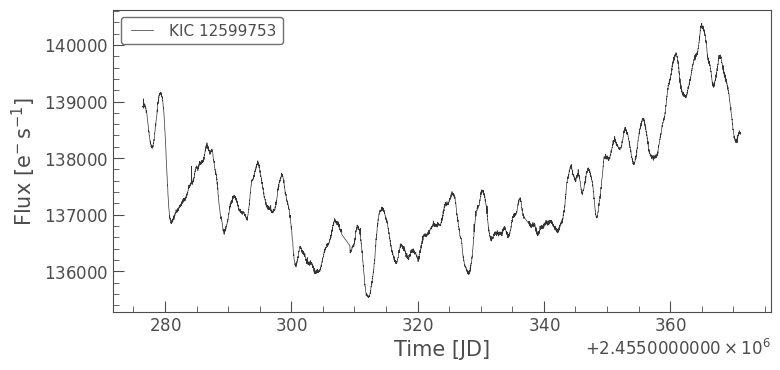

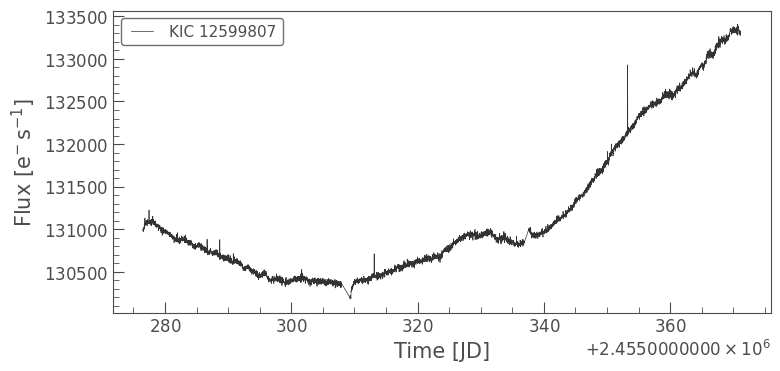

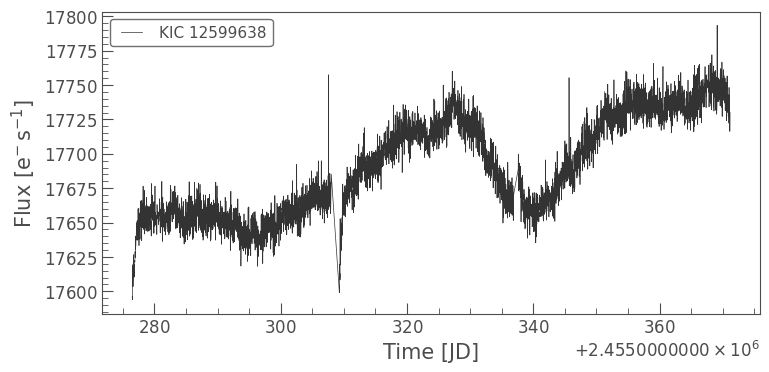

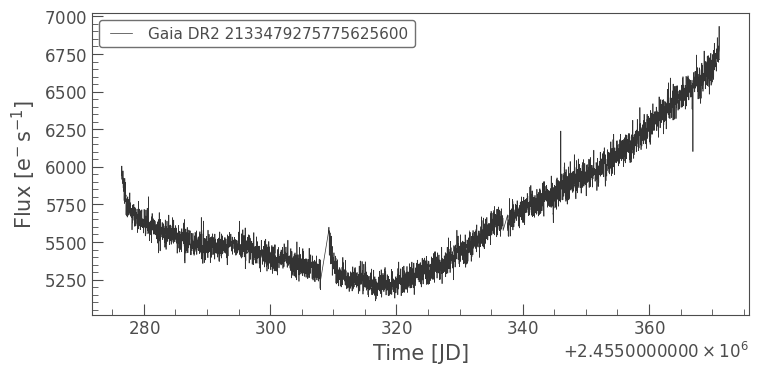

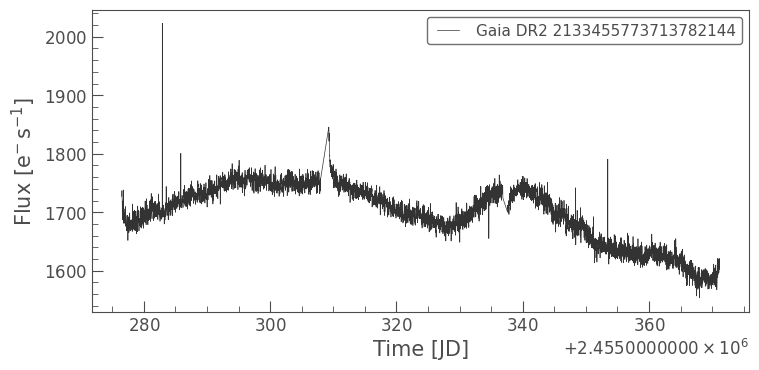

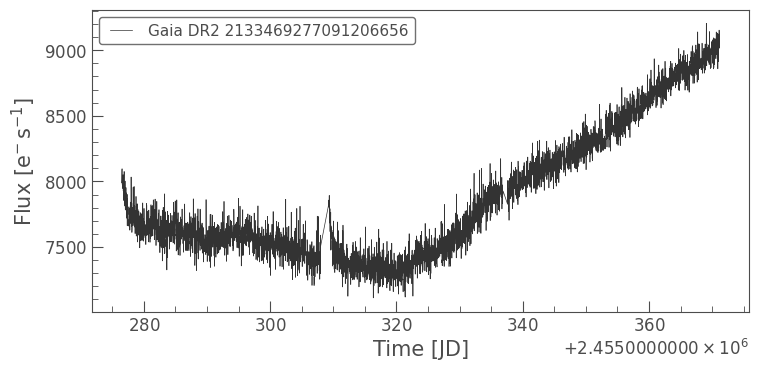

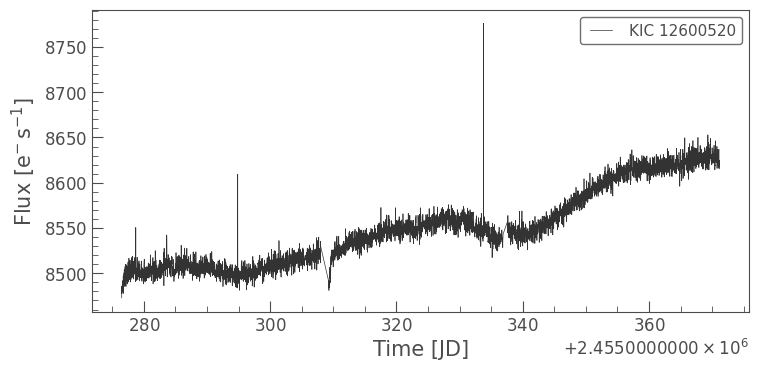

In [10]:
for lc in machine.lcs[::25]:
    if np.isnan(lc.flux).all():
        continue
    ax = lc.plot()
    plt.show()